# Operações de mutação
Após executar o notebook de **classificação**, podemos realizar operações de mutação no texto para verificar qual impacto elas têm na classificação dos níveis de dificuldade do texto.

In [1]:
import pandas as pd
import numpy as np
import random

random.seed(8)

## Leitura dos dados

In [2]:
# Read dataset into Pandas DataFrame
df = pd.read_csv('dataset.csv', index_col='id')
df.head()

,text,label
id,,
207_765,"nada impede, no entanto, que sejam substituído...",1
232_790,e muitas palavras faladas por esses povos fora...,1
39_347,"sete séculos antes do nascimento de cristo, o ...",1
48_379,voar sempre foi um dos grandes sonhos da human...,1
73_629,"para os bolsos de seus senhores, é claro. você...",1


In [3]:
# download nltk required packages
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/caio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/caio/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [21]:
import pickle
import os
from src.CustomPortugueseLemmatizer import CustomPortugueseLemmatizer

path = 'pickle'
if os.path.isdir(path):
    # Read the Naive Bayes classifier from pickle
    with open(f'{path}/pipeline_NB.pickle', 'rb') as nb_pickle:
        pipeNB = pickle.load(nb_pickle)

    # Read the SVC classifier from pickle
    with open(f'{path}/pipeline_SVC.pickle', 'rb') as svc_pickle:
        pipeSVC = pickle.load(svc_pickle)

## Troca de palavras

In [7]:
from nltk.corpus import wordnet 

def get_synonyms(word):
    """
    Get synonyms of a word
    """
    synonyms = set()
    
    for syn in wordnet.synsets(word, lang='por'): 
        for l in syn.lemmas(lang='por'): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklçzxcvbnmáàãâéêíóõôúü'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

In [42]:
def synonym_replacement(words, stop_words, n):
    if n <= 0: # no word to replace, return the original text
        return words
        
    words = words.split()

    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

### Teste com um texto exemplo

In [43]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)

In [44]:
# Retrieve the last text from the test set
text = X_test.iloc[-1]
print(text)

a prostituição é uma atividade antiquíssima e que sempre encontra espaço nas sociedades. em geral, os clientes procuram esse tipo de profissional porque têm dificuldades de conseguir parceiros sexuais ou então para procurar diversidade em seus relacionamentos sexuais. porém, em termos psicológicos, geralmente é uma relação desprovida de afeto. e o sexo, dizem as pesquisas, é mais gratificante quando expressa um real sentimento entre os parceiros. durante a relação sexual, são comuns os gritos, gemidos, sussurros e palavreados obscenos, supostamente denotando excitação sexual. porém estudos recentes indicam que, na maioria das vezes, tal comportamento não reflete real excitação sexual, mas apenas o desejo de estimular sexualmente o parceiro. existem uma diferenciação no papel de cada gênero sexual dentro da relação afetiva. estudos indicam, por exemplo, que um casamento tem mais chances de ser bem-sucedido se a mulher for mais inteligente, mais jovem ou mais feliz com a relação que o ho

In [45]:
import spacy

nlp = spacy.load("pt_core_news_sm")
stop_words = nlp.Defaults.stop_words

In [46]:
sentence = synonym_replacement(text, stop_words, len(text.split()) * 0.5)
print(sentence)

a prostituição é uma ação antiquíssima e que sempre encontra espaço nas sociedades. em geral, os clientes procuram esse tipo de praticante porque têm dificuldades de ser bem sucedidos parceiros sexuais ou então para revistar diversidade em seus relacionamentos sexuais. porém, em termos psicológicos, popularmente é uma relação desprovida de afeto. e o sexo, dizem as pesquisas, é mais gratificante quando expressa um efectivo emoção entre os parceiros. durante a relação sexual, são comuns os gritos, gemidos, sussurros e palavreados obscenos, alegada denotando emoção sexual. porém estudos recentes indicam que, na maioria das vezes, tal procedimento não reflete efectivo emoção sexual, mas apenas o anelo de incitar sexualmente o parceiro. existem uma diferenciação biologia no folha de cada género gramatical sexual dentro da relação afetiva. estudos indicam, por exemplo, que um matrimônio tem mais chance de ser bem sucedido se a dona for mais inteligente, mais menininha ou mais contente com a

In [12]:
# Create list of texts to predict
X_eval = [text]
label_NB = pipeNB.predict(X_eval)
label_SVC = pipeSVC.predict(X_eval)

print(f'Naive Bayes label: {label_NB}')
print(f'SVC label: {label_SVC}')
print(f'Correct label: {y_test[-1]}')

Naive Bayes label: [4]
SVC label: [3]
Correct label: 3


### Avaliação da influência da troca de palavras

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
accuracy_NB = []
accuracy_SVC = []

percentage_range = np.arange(0, 1, step=0.05)
for percent in percentage_range:
    X_test_syn  = [synonym_replacement(text, len(text.split()) * percent) for text in X_test]
    
    predictions_NB = pipeNB.predict(X_test_syn)
    accuracy_NB.append(accuracy_score(y_test, predictions_NB))
    predictions_SVC = pipeSVC.predict(X_test_syn)
    accuracy_SVC.append(accuracy_score(y_test, predictions_SVC))

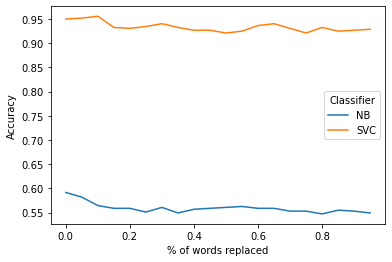

In [15]:
import matplotlib.pyplot as plt

plt.plot(percentage_range, accuracy_NB, label='NB')
plt.plot(percentage_range, accuracy_SVC, label='SVC')
plt.ylabel('Accuracy')
plt.xlabel('% of words replaced')
plt.legend(title='Classifier')
plt.savefig('figures/accuracy_replacement.png', dpi=200)
plt.show()

## Paráfrase

In [16]:
!pip install deep-translator

In [17]:
from deep_translator import GoogleTranslator

In [18]:
supported_languages = GoogleTranslator.get_supported_languages()
print(f'Number of supported languages: {len(supported_languages)}')
print(supported_languages)

Number of supported languages: 109
['afrikaans', 'albanian', 'amharic', 'arabic', 'armenian', 'azerbaijani', 'basque', 'belarusian', 'bengali', 'bosnian', 'bulgarian', 'catalan', 'cebuano', 'chichewa', 'chinese (simplified)', 'chinese (traditional)', 'corsican', 'croatian', 'czech', 'danish', 'dutch', 'english', 'esperanto', 'estonian', 'filipino', 'finnish', 'french', 'frisian', 'galician', 'georgian', 'german', 'greek', 'gujarati', 'haitian creole', 'hausa', 'hawaiian', 'hebrew', 'hindi', 'hmong', 'hungarian', 'icelandic', 'igbo', 'indonesian', 'irish', 'italian', 'japanese', 'javanese', 'kannada', 'kazakh', 'khmer', 'kinyarwanda', 'korean', 'kurdish', 'kyrgyz', 'lao', 'latin', 'latvian', 'lithuanian', 'luxembourgish', 'macedonian', 'malagasy', 'malay', 'malayalam', 'maltese', 'maori', 'marathi', 'mongolian', 'myanmar', 'nepali', 'norwegian', 'odia', 'pashto', 'persian', 'polish', 'portuguese', 'punjabi', 'romanian', 'russian', 'samoan', 'scots gaelic', 'serbian', 'sesotho', 'shona',

In [19]:
translated = GoogleTranslator(source='pt', target='en').translate(text)
back_translated = GoogleTranslator(source='en', target='pt').translate(translated)

print(f'Original Text [pt]: {text}\n')
print(f'Translated Text [en]: {translated}\n')
print(f'Back Translation [pt]: {back_translated}')

Original Text [pt]: a prostituição é uma atividade antiquíssima e que sempre encontra espaço nas sociedades. em geral, os clientes procuram esse tipo de profissional porque têm dificuldades de conseguir parceiros sexuais ou então para procurar diversidade em seus relacionamentos sexuais. porém, em termos psicológicos, geralmente é uma relação desprovida de afeto. e o sexo, dizem as pesquisas, é mais gratificante quando expressa um real sentimento entre os parceiros. durante a relação sexual, são comuns os gritos, gemidos, sussurros e palavreados obscenos, supostamente denotando excitação sexual. porém estudos recentes indicam que, na maioria das vezes, tal comportamento não reflete real excitação sexual, mas apenas o desejo de estimular sexualmente o parceiro. existem uma diferenciação no papel de cada gênero sexual dentro da relação afetiva. estudos indicam, por exemplo, que um casamento tem mais chances de ser bem-sucedido se a mulher for mais inteligente, mais jovem ou mais feliz co

In [36]:
len(X_test[69])

4999

In [28]:
X_test_trans = []

for text in X_test:
    translated = GoogleTranslator(source='pt', target='en').translate(text)
    if len(translated) < 5000:
        back_translated = GoogleTranslator(source='en', target='pt').translate(translated)
        X_test_trans.append(back_translated)
    else:
        X_test_trans.append(text)

NotValidLength: the inverse hyperbolic functions are particularly interesting, they are linked to the natural logarithm and for this reason, their analysis is essentially exponential, like the analysis of hyperbolic functions, this fact gives rise to new possibilities to deal with problems related to the analysis of non-linear structures. hyperbolic functions are characteristically analyzed in a similar way to trigonometric ones, which suggests the analysis of the inversion of variables from hyperbolic equations of the form: formula_251, to the form: formula_252 this is particularly easy to implement for functions of type formula_253, which are functions monotonous and continuous, for the others that restrict their continuity in a certain interval, we must adopt bands for the domain of each one in particular. It is important to note that, although hyperbolic functions are similar to trigonometric functions, these functions are based on angles that must be analyzed differently from trigonometric ones, remember that the radius of a circular function is constant, which does not happen with a function based on a conic, in this case the hyperbola, that's why we chose the name "argfunch(x) ", because we can't classify the hyperbolic angles as arcs. now let's consider the function formula_254, then: formula_255 we can do formula_256, so: formula_257 which results in the equation: formula_258 whose roots are: formula_259 we can only admit: formula_260, hence: formula_261 replacing the variables "x" with "y" and "t " by "x", we have the inverse of formula_253 which is: in the case of formula_264, the deduction is similar: formula_265 we can do formula_256, so: formula_267 which results in the equation: formula_268 whose roots are: formula_269 we can only admit: formula_260, consequently: formula_271 replacing the variables "x" with "y" and "t" with "x", we have the inverse of formula_272 which is: considering the formulas deduced above, we have: formula_275 from which we deduce: formula_276 formula_277 resulting: and for formula_279 from which we deduce: formula_280 formula_281 and finally: the integrals of these functions need a different treatment, using the methods of the next chapter: integration techniques, I propose that and the reader makes them as an exercise of the same. considering formula_284, we have: formula_285 if formula_286: formula_287 which results in the equation: formula_288 whose roots are: formula_289 where we can only admit formula_290 and formula_291: formula_292 replacing "x" with "y" and "t" with "x": formula_293 that is the inverse of formula_294, therefore: considering formula_299, we have: formula_300 if formula_286: formula_302 which results in the equation: formula_303 whose roots are: formula_304 where we can only admit formula_290 and formula_306: formula_307 replacing "x" with "y" and "t " by "x": formula_308 which is the inverse of formula_309, so: be formula_312 formula_313, formula_314 we deduce that its derivative is: formula_315 which, after being subjected to the chain rule and reason, becomes: formula_316 formula_317 formula_318 and finally : note that due to the domain limitation imposed by the variable in the primitive function, the derivative inherits the same limitation, since the function does not exist outside this domain. be formula_321 formula_322, we deduce that its derivative is: formula_323 which, after being subjected to the chain rule and reason, becomes: formula_324 formula_325 formula_326 and, finally: the integrals of these functions need a different treatment, using the methods of next chapter: integration techniques, I propose that the reader do them as an exercise of the same. considering formula_328, we have: formula_329 if formula_286: formula_331 which results in the equation: formula_332 whose roots are: formula_333 where we can only admit formula_290 and formula_291: formula_336 replacing "x" with "y" and "t" with "x": formula_337 that is the inverse of formula_338, therefore: considering formula_343, we have: formula_344 if formula_286: formula_346 which results in the equation: formula_347 whose roots are: formula_348 where we can only admit formula_290: formula_350 replacing "x" with "y" and "t" with "x": formula_351 which is the inverse of formula_352, so: either formula_354 formula_355, formula_156 we deduce that its derivative is: formula_357 which, after being subjected to the chain and ratio rule, becomes: formula_358 formula_359 formula_360 and finally: note that, due to the limitation of the domain imposed by the variable in the primitive function, the derivative inherits the same limitation, since the function does not exist outside this domain. be formula_363 formula_364, we deduce that its derivative is: formula_365 which, after being subjected to the chain rule and reason, becomes: formula_366 formula_367 formula_368 and, finally: the integrals of these functions need a different treatment, using the methods of next chapter: integration techniques, I propose that the reader do them as an exercise of the same. --> Text length need to be between 1 and 5000 characters

In [31]:
len(X_test)

519

In [30]:
len(X_test_trans)

69

In [33]:
predictions_NB = pipeSVC.predict(X_test)
predictions_NBtrans = pipeSVC.predict(X_test_trans)

print(f'SVC accuracy (original): {accuracy_score(y_test, predictions_NB):.2f}')
print(f'SVC accuracy (back_translated): {accuracy_score(y_test, predictions_NBtrans):.2f}')

predictions_SVC = pipeSVC.predict(X_test)
predictions_SVCtrans = pipeSVC.predict(X_test_trans)

print(f'SVC accuracy (original): {accuracy_score(y_test, predictions_SVC):.2f}')
print(f'SVC accuracy (back_translated): {accuracy_score(y_test, predictions_SVCtrans):.2f}')

SVC accuracy (original): 0.95


ValueError: Found input variables with inconsistent numbers of samples: [519, 69]